# 基于VAE的手写数字生成

## 小组介绍

小组成员:徐文斌(2010234)、靳乐卿(2012159)、马琦(2011600)

## 小组分工

- VAE理论书写及Loss式子推导(马琦)

- 基础VAE搭建(靳乐卿、马琦)

- $\beta$-VAE的搭建(徐文斌)

- 基于t-SNE、PCA的隐变量Z可视化(马琦)

- GAN的搭建及与VAE的对比(徐文斌)

- VAE-GAN的搭建及理论分析(靳乐卿)

## 基本要求:VAE的实现——从AE到VAE

### 自编码器

我们从自编码器（AutoEncoder，AE）出发。自编码器的初衷是为了数据降维，假设原始特征x维度过高，那么我们希望通过编码器E将其编码成低维特征向量z=E(x)，编码的原则是尽可能保留原始信息，因此我们再训练一个解码器D，希望能通过z重构原始信息，即x≈D(E(x))，其优化目标一般是
$$\begin{equation}E,D = \mathop{\arg\min}_{E,D}\mathbb{E}_{x\sim \mathcal{D}}\big[\Vert x - D(E(x))\Vert^2\big]\end{equation}$$

说白了，就是让编码后的结果通过解码器解码完与最初输入给编码器的数据尽量相等。

假如我们现在得到了这样一组理想的自编码器$E_{exp}(·)$和$D_{exp}(·)$，那么我们可以用如下式子表示其工作的过程:
对于输入$\forall x$
$$z = E_{exp}(x)$$
$$\tilde{x} = D_{exp}(z)$$
$$\tilde{x} = x$$

我们可以把$z$当做是$x$的等价表示，也就是说编码器相当于提供了一组$x$和$z$一一映射的关系。这样我们研究$z$就是研究$x$，我们就达到了开头所说的降维+保留原始信息的目的。

### 直观理解VAE

那么显然，上面说的这些在现实中太过苛刻，经过原始编码器后生成的特征向量，其分布可能非常得差，比如它可能非常得混乱，没什么规律(这个形状非常好想象)，或者太过集中(比如一条直线，甚至一个点)，这种说明编码后的向量的维度存在冗余。又或者在两个均有分布的区域之间的区域不存在分布，这样我们的分布是不连续的。如下图
![jupyter](./disappropriate.png)
我们理想的是一种分布规整，无冗余，连续的一段分布空间，我们从中学习了一些样本，很容易泛化到未知的新样本上，我们知道训练样本的编码向量之间的“缝隙”也是存在真实样本的，那么如果编码空间是规整和连续的，我们很容易通过之前学习的规律推演出未知的真实样本，如下图
![jupyter](./appropriate.png)

那么为了产生合适的编码空间，我们的VAE(Variational AutoEncoder)就应运而生，他的目的主要为：1.让编码空间更规整一些；2.让编码向量更紧凑一些。而VAE解决这一问题的主要手段是引入后验分布，即考虑$p(z|x)$。这样做一个最直观的效果就是把我们原来的一个点扩展成一个区域，在这个区域对应的很多个点，他们对应的是不同的概率。那么进而我们就实现了让编码向量更紧凑的目的(点的位置没有变，但是他覆盖的区域变大了，那么区域间的距离显然是更小的.) 
我们选择用正态分布(即$N(\mu, \sigma)$)来描述这个分布，这一点是因为所有的概率分布都可以用多个正态分布去描述，故我们得到数学表达如下:

$$\begin{equation}\mu,\sigma,D = \mathop{\arg\min}_{\mu,\sigma,D}\mathbb{E}_{x\sim \mathcal{D}}\big[\Vert x - D(\mu(x) + \varepsilon\otimes \sigma(x))\Vert^2\big],\quad \varepsilon\sim \mathcal{N}(0, 1)\end{equation}$$

这个式子的意思就是说，我们要求得这样一组变化，使得对编码后再解码的结果与原来差距最小(这是之前的理论),而编码的方式则是通过$\mu、\sigma$来完成的。

到了这一步，我们也才完成了目标的一半，而编码空间此时可能并不规整，在VAE中，我们希望所有编码向量符合正态分布，也就是所有的覆盖区域都尽量统一为$N(0,1)$的分布(应该只是为了方便操作)，这样的话，我们的编码空间就会非常得规整了，因为每一个都差不多。我们进而就得到了式子:

$$\begin{equation}\mathbb{E}_{x\sim \mathcal{D}}\left[\sum_{i=1}^d \frac{1}{2}\Big(\mu_{i}^2(x) + \sigma_{i}^2(x) - \log \sigma_{i}^2(x) - 1\Big)\right]\end{equation}$$

这个式子就是KL散度的最终表示，具体的在我们后面的中级要求中有详细推导。上面的这个式子我们可以暂时理解为每一个小的概率分布和标准正态分布之间的差别，我们自然是要让上面的值越小越好，那么到这里，我们的两个部分就都已经明晰，最终我们总的$Loss$表达式可以写作:

$$\begin{equation}\mathbb{E}_{x\sim \mathcal{D}}\big[\Vert x - D(\mu(x) + \varepsilon\otimes \sigma(x))\Vert^2 + \sum_{i=1}^d \frac{1}{2}\Big(\mu_{i}^2(x) + \sigma_{i}^2(x) - \log \sigma_{i}^2(x) - 1\Big)\big], \quad \varepsilon\sim \mathcal{N}(0, 1)\end{equation}$$

这个式子和VAE给出的$Loss$表达式是很接近的。主要区别在于第一项，这个也就是资料中所提到的“重参数化”，这里可以认为，$\mu$就是自编码器中的编码器，而$\sigma$对应的是其泛化能力，这样的话，我们的模型就有了训练的功能.当然，这里存在一个显然的问题，就是为什么二者是直接相加，其比例该如何把握。这里我们直接引入$\beta$-VAE模型，通过调整$\beta$的值来改变二者的权重。特别的，当$\beta$ = 1时，就是VAE.

### VAE中的对抗关系

当然，之前的阐述主要是为了直观地(从几何方面)思考VAE的用意，有一定的**不严谨之处**，主要在于:我们会将$Loss$分成两部分看，认为VAE的解决思路就是分别最小化差别和KL散度。那么这种想法其实是原VAE的一个充分不必要条件。我们可以思考一下，如果KL散度取0时，这意味着$z$没有任何辨识度，那么对于前者而言必定非常大的。而如果前者很小，那么$p(z|x)$其实随机性就没有那么大，那么此时KL散度一定不会小的。这种关系反映的就是$Loss$两项整体的对抗关系，所以我们不能单从某个项去看，而应该从整体的角度，整个$Loss$越小，模型才会收敛，效果才会好。

### 从贝叶斯观点看VAE

#### 为什么叫VAE

这一部分主要是由于我们在模型中使用到了KL散度来度量两个概率分布之间的差异，即
$$KL\Big(p(x)\Big\Vert q(x)\Big) = \int p(x)\ln \frac{p(x)}{q(x)} dx=\mathbb{E}_{x\sim p(x)}\left[\ln \frac{p(x)}{q(x)}\right]$$

最小化KL散度的终极就是二者完全相等，此时显然KL散度为0，这一点需要用到[变分推导](https://blog.csdn.net/weixin_39642761/article/details/110804095)。

#### 直通VAE的Loss

我们的这个模型，主要就是为了使得两个分布$p(x,z)$和$q(x,z)$越接近越好，那么我们根据KL散度的式子，有
$$KL\Big(p(x,z)\Big\Vert q(x,z)\Big) = \iint p(x,z)\ln \frac{p(x,z)}{q(x,z)} dzdx$$

根据式子
$$q(x)=\int q(x|z)q(z)dz,\quad q(x,z) = q(x|z)q(z）$$
我们又可以进一步地化简
$$\begin{aligned}KL\Big(p(x,z)\Big\Vert q(x,z)\Big) =& \int \tilde{p}(x) \left[\int p(z|x)\ln \frac{\tilde{p}(x)p(z|x)}{q(x,z)} dz\right]dx\\ 
=& \mathbb{E}_{x\sim \tilde{p}(x)} \left[\int p(z|x)\ln \frac{\tilde{p}(x)p(z|x)}{q(x,z)} dz\right]\\
=& \mathbb{E}_{x\sim \tilde{p}(x)} \left[\int p(z|x)(\ln \tilde{p}(x) + \ln \frac{p(z|x)}{q(x,z)} )dz\right]\\
=&\mathbb{E}_{x\sim \tilde{p}(x)} \big[\ln \tilde{p}(x)\big] + \mathbb{E}_{x\sim \tilde{p}(x)} \left[\int p(z|x)\ln \frac{p(z|x)}{q(x,z)}dz\right]\\
=&\mathbb{E}_{x\sim \tilde{p}(x)} \big[\ln \tilde{p}(x)\big] + \mathbb{E}_{x\sim \tilde{p}(x)} \left[-\int p(z|x)\ln q(x|z)dz+\int p(z|x)\ln \frac{p(z|x)}{q(z)}dz\right]\\
=&\mathbb{E}_{x\sim \tilde{p}(x)} \left[\mathbb{E}_{z\sim p(z|x)}\big[-\ln q(x|z)\big]+\mathbb{E}_{z\sim p(z|x)}\Big[\ln \frac{p(z|x)}{q(z)}\Big]\right] + \mathbb{C}\\ 
= &\mathbb{E}_{x\sim \tilde{p}(x)} \Bigg[\mathbb{E}_{z\sim p(z|x)}\big[-\ln q(x|z)\big]+KL\Big(p(z|x)\Big\Vert q(z)\Big)\Bigg] + \mathbb{C}
\end{aligned}$$

这时我们发现，所求的式子正是损失函数，其中$\mathbb{E}_{x\sim \tilde{p}(x)} \big[\ln \tilde{p}(x)\big]$是$x$的先验分布所求出来，就是确定的一项，所以我们直接把它看作常数就可以了。最终我们要想使得二者的分布最为接近，那么只需要最小化前一项即可。

那么到这里，我们基本完成了对VAE的理解，接下来我们将编写代码进行实现。

![网络结构示意图](./Structure.png)

### VAE的搭建

在本部分我们搭建了VAE的主要框架，为了节省流程，我们直接将模型的损失函数引入超参数$\beta$。即
$$Loss = ELBO=E_{z∼q(z|x)}logp(x|z)dz−\beta × KL(q(z|x)||p(z))$$
其中,$\beta$的取值从小数到大于1的整数，分别对应二者某一项更重要或者同样重要，方便我们判断到底$Loss$中哪一项是训练的关键。

In [1]:
# 需要提前安装Pytorch和对应版本的torchvision
import os
import torch
import torch.utils.data as Data
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from torchvision.utils import save_image
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# 下载数据集
dataset = MNIST(
    root='MNIST',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
batch_sz = 128   # 数据集切分，每个batch大小为128
dataIter = Data.DataLoader(dataset, batch_size=batch_sz, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\train-images-idx3-ubyte.gz to MNIST\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST\MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\MNIST\raw



In [4]:
# 查看张量的维度数：N(num),C(channel),H(height),W(width)
x, y = next(iter(dataIter))
x.shape  # torch.Size([128, 1, 28, 28]), 表示每个batch有128张图，只有一个channel(黑白)，长宽分别是28*28

torch.Size([128, 1, 28, 28])

In [5]:
# 展平
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)   # torch.Size([128, 784])

In [6]:
# 简单建一个VAE
Z_dim=2
H_dim=256
Count_size=784
class VAE(nn.Module):
    def __init__(self, count_size = Count_size, h_dim=H_dim, z_dim=Z_dim):  
        # 输入维度是784，中间Encoder、Decoder的维度是256，隐变量维度是20
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(count_size, h_dim)  # Encoder
        self.fc2 = nn.Linear(h_dim, z_dim)  # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim)  # 方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)  # Decoder
        self.fc5 = nn.Linear(h_dim, count_size)  # output

    # 编码
    def encode(self, x):
        h= F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    # 重参数化生成隐变量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))

    # 整个前向传播过程：编码 --> 解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

In [7]:
def train_module(beta,lossfunc=F.cross_entropy):    
    # 训练模型
    #torch.cuda.set_device(1) # 这句⽤来设置pytorch在哪块GPU上运⾏
    device = torch.device('cuda')
    learning_rate = 10e-3  # 学习率
    epoches = 20  # 迭代20次

    # 实例化一个模型

    model = VAE().to(device)

    # 创建优化器
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 训练
    train_loss = [0.] * epoches  # 保存每个epoch的训练误差
    for epoch in range(epoches):
        for i, (x, y) in enumerate(dataIter):
            # 展平并训练
            x = flatten(x).cuda()
            x_reconst, mu, log_var = model(x)
            # 计算损失函数
            reconst_loss=lossfunc(x_reconst, x, size_average=False)
            # KL散度的计算
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) * beta
            # 反向传播和优化
            loss = reconst_loss + kl_div
            opt.zero_grad()
            loss.backward()
            opt.step()
            train_loss[epoch]=train_loss[epoch]+loss.cuda()
            # 输出batch信息
            if i % 200 == 0 and i > 0:
                print("epoch : {0} | #batch : {1} | batch average loss: {2}"
                      .format(epoch, i, loss.cuda().item()/len(x)))

        # 输出epoch信息
        print("epoch[{}/{}] | loss:{}"
                          .format(epoch, epoches, train_loss[epoch] / len(dataIter.dataset)))
    return model

e:\anaconda3\envs\ml\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
e:\anaconda3\envs\ml\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch : 0 | #batch : 200 | batch average loss: 42.01055908203125
epoch : 0 | #batch : 400 | batch average loss: 40.43532180786133
epoch[0/20] | loss:42.90766143798828
epoch : 1 | #batch : 200 | batch average loss: 37.81912612915039
epoch : 1 | #batch : 400 | batch average loss: 40.6029052734375
epoch[1/20] | loss:38.773643493652344
epoch : 2 | #batch : 200 | batch average loss: 38.67584991455078
epoch : 2 | #batch : 400 | batch average loss: 37.64388656616211
epoch[2/20] | loss:37.94039535522461
epoch : 3 | #batch : 200 | batch average loss: 38.23841857910156
epoch : 3 | #batch : 400 | batch average loss: 39.4256477355957
epoch[3/20] | loss:37.4450569152832
epoch : 4 | #batch : 200 | batch average loss: 36.829811096191406
epoch : 4 | #batch : 400 | batch average loss: 35.4901008605957
epoch[4/20] | loss:37.17774200439453
epoch : 5 | #batch : 200 | batch average loss: 37.91945266723633
epoch : 5 | #batch : 400 | batch average loss: 34.581207275390625
epoch[5/20] | loss:36.79561614990234

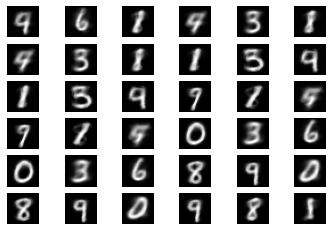

epoch : 0 | #batch : 200 | batch average loss: 669.3472290039062
epoch : 0 | #batch : 400 | batch average loss: 649.2356567382812
epoch[0/20] | loss:634.923583984375
epoch : 1 | #batch : 200 | batch average loss: 652.7238159179688
epoch : 1 | #batch : 400 | batch average loss: 639.262939453125
epoch[1/20] | loss:632.7483520507812
epoch : 2 | #batch : 200 | batch average loss: 645.9907836914062
epoch : 2 | #batch : 400 | batch average loss: 629.5882568359375
epoch[2/20] | loss:632.3419799804688
epoch : 3 | #batch : 200 | batch average loss: 617.065185546875
epoch : 3 | #batch : 400 | batch average loss: 653.1966552734375
epoch[3/20] | loss:632.0966186523438
epoch : 4 | #batch : 200 | batch average loss: 636.2811279296875
epoch : 4 | #batch : 400 | batch average loss: 619.3630981445312
epoch[4/20] | loss:631.9219360351562
epoch : 5 | #batch : 200 | batch average loss: 641.7860107421875
epoch : 5 | #batch : 400 | batch average loss: 619.3446044921875
epoch[5/20] | loss:631.8026123046875
e

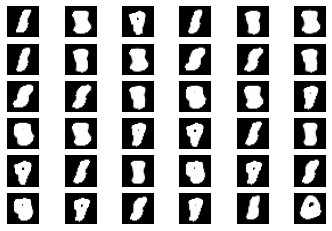

epoch : 0 | #batch : 200 | batch average loss: 42.11699676513672
epoch : 0 | #batch : 400 | batch average loss: 42.005279541015625
epoch[0/20] | loss:44.62931823730469
epoch : 1 | #batch : 200 | batch average loss: 39.3246955871582
epoch : 1 | #batch : 400 | batch average loss: 43.64668273925781
epoch[1/20] | loss:41.06847381591797
epoch : 2 | #batch : 200 | batch average loss: 36.139137268066406
epoch : 2 | #batch : 400 | batch average loss: 40.606163024902344
epoch[2/20] | loss:40.445404052734375
epoch : 3 | #batch : 200 | batch average loss: 39.55980682373047
epoch : 3 | #batch : 400 | batch average loss: 41.9194221496582
epoch[3/20] | loss:40.06557846069336
epoch : 4 | #batch : 200 | batch average loss: 39.32276916503906
epoch : 4 | #batch : 400 | batch average loss: 39.5648307800293
epoch[4/20] | loss:39.716461181640625
epoch : 5 | #batch : 200 | batch average loss: 41.114131927490234
epoch : 5 | #batch : 400 | batch average loss: 39.22911834716797
epoch[5/20] | loss:39.5672225952

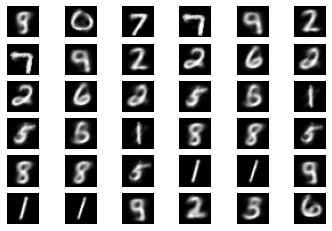

epoch : 0 | #batch : 200 | batch average loss: 635.4052734375
epoch : 0 | #batch : 400 | batch average loss: 626.0411376953125
epoch[0/20] | loss:635.801513671875
epoch : 1 | #batch : 200 | batch average loss: 636.4957275390625
epoch : 1 | #batch : 400 | batch average loss: 632.9786376953125
epoch[1/20] | loss:634.2862548828125
epoch : 2 | #batch : 200 | batch average loss: 627.3981323242188
epoch : 2 | #batch : 400 | batch average loss: 639.1602783203125
epoch[2/20] | loss:634.0071411132812
epoch : 3 | #batch : 200 | batch average loss: 664.7919921875
epoch : 3 | #batch : 400 | batch average loss: 625.9608764648438
epoch[3/20] | loss:633.8287353515625
epoch : 4 | #batch : 200 | batch average loss: 621.9934692382812
epoch : 4 | #batch : 400 | batch average loss: 629.4957885742188
epoch[4/20] | loss:633.7356567382812
epoch : 5 | #batch : 200 | batch average loss: 649.9611206054688
epoch : 5 | #batch : 400 | batch average loss: 635.6889038085938
epoch[5/20] | loss:633.62060546875
epoch :

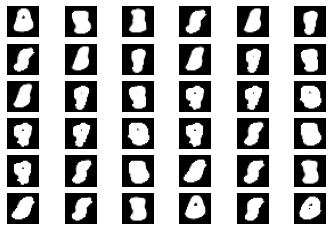

epoch : 0 | #batch : 200 | batch average loss: 47.24601745605469
epoch : 0 | #batch : 400 | batch average loss: 45.53611755371094
epoch[0/20] | loss:49.41651153564453
epoch : 1 | #batch : 200 | batch average loss: 45.32217025756836
epoch : 1 | #batch : 400 | batch average loss: 48.144012451171875
epoch[1/20] | loss:46.28508758544922
epoch : 2 | #batch : 200 | batch average loss: 46.26411056518555
epoch : 2 | #batch : 400 | batch average loss: 46.09294509887695
epoch[2/20] | loss:45.78669738769531
epoch : 3 | #batch : 200 | batch average loss: 42.86289978027344
epoch : 3 | #batch : 400 | batch average loss: 46.253028869628906
epoch[3/20] | loss:45.46846389770508
epoch : 4 | #batch : 200 | batch average loss: 43.57757568359375
epoch : 4 | #batch : 400 | batch average loss: 45.04585647583008
epoch[4/20] | loss:45.2686653137207
epoch : 5 | #batch : 200 | batch average loss: 42.39591979980469
epoch : 5 | #batch : 400 | batch average loss: 42.94929122924805
epoch[5/20] | loss:45.188529968261

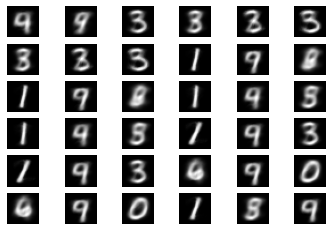

epoch : 0 | #batch : 200 | batch average loss: 609.1517333984375
epoch : 0 | #batch : 400 | batch average loss: 607.2261352539062
epoch[0/20] | loss:637.0025024414062
epoch : 1 | #batch : 200 | batch average loss: 633.5167846679688
epoch : 1 | #batch : 400 | batch average loss: 610.8822631835938
epoch[1/20] | loss:636.1546630859375
epoch : 2 | #batch : 200 | batch average loss: 641.2619018554688
epoch : 2 | #batch : 400 | batch average loss: 651.44873046875
epoch[2/20] | loss:635.8273315429688
epoch : 3 | #batch : 200 | batch average loss: 643.0084228515625
epoch : 3 | #batch : 400 | batch average loss: 633.6759643554688
epoch[3/20] | loss:635.6211547851562
epoch : 4 | #batch : 200 | batch average loss: 655.0778198242188
epoch : 4 | #batch : 400 | batch average loss: 622.2885131835938
epoch[4/20] | loss:635.5447387695312
epoch : 5 | #batch : 200 | batch average loss: 640.46044921875
epoch : 5 | #batch : 400 | batch average loss: 593.1580200195312
epoch[5/20] | loss:635.4639892578125
ep

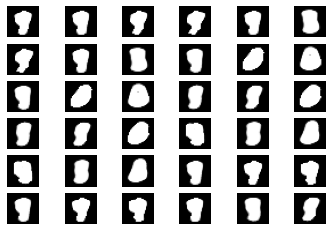

epoch : 0 | #batch : 200 | batch average loss: 49.01027297973633
epoch : 0 | #batch : 400 | batch average loss: 47.8960075378418
epoch[0/20] | loss:50.08831024169922
epoch : 1 | #batch : 200 | batch average loss: 48.66535949707031
epoch : 1 | #batch : 400 | batch average loss: 48.07514190673828
epoch[1/20] | loss:47.544857025146484
epoch : 2 | #batch : 200 | batch average loss: 46.77134323120117
epoch : 2 | #batch : 400 | batch average loss: 48.11146926879883
epoch[2/20] | loss:47.140750885009766
epoch : 3 | #batch : 200 | batch average loss: 46.1319580078125
epoch : 3 | #batch : 400 | batch average loss: 45.96742630004883
epoch[3/20] | loss:46.95988082885742
epoch : 4 | #batch : 200 | batch average loss: 45.84703063964844
epoch : 4 | #batch : 400 | batch average loss: 48.25265121459961
epoch[4/20] | loss:46.84612274169922
epoch : 5 | #batch : 200 | batch average loss: 45.93781280517578
epoch : 5 | #batch : 400 | batch average loss: 48.42578887939453
epoch[5/20] | loss:46.7708473205566

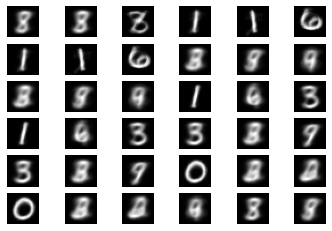

epoch : 0 | #batch : 200 | batch average loss: 630.429931640625
epoch : 0 | #batch : 400 | batch average loss: 661.347900390625
epoch[0/20] | loss:638.4075927734375
epoch : 1 | #batch : 200 | batch average loss: 645.8425903320312
epoch : 1 | #batch : 400 | batch average loss: 597.728759765625
epoch[1/20] | loss:638.0504760742188
epoch : 2 | #batch : 200 | batch average loss: 632.821533203125
epoch : 2 | #batch : 400 | batch average loss: 622.6483154296875
epoch[2/20] | loss:638.0308837890625
epoch : 3 | #batch : 200 | batch average loss: 627.310302734375
epoch : 3 | #batch : 400 | batch average loss: 623.936767578125
epoch[3/20] | loss:638.0201416015625
epoch : 4 | #batch : 200 | batch average loss: 650.8018188476562
epoch : 4 | #batch : 400 | batch average loss: 618.4238891601562
epoch[4/20] | loss:638.0098876953125
epoch : 5 | #batch : 200 | batch average loss: 659.4073486328125
epoch : 5 | #batch : 400 | batch average loss: 623.5467529296875
epoch[5/20] | loss:638.0028076171875
epoc

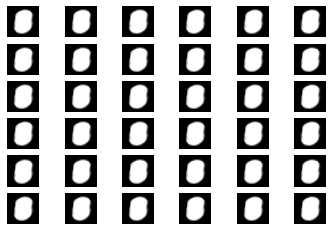

epoch : 0 | #batch : 200 | batch average loss: 51.74836730957031
epoch : 0 | #batch : 400 | batch average loss: 49.80268478393555
epoch[0/20] | loss:52.482826232910156
epoch : 1 | #batch : 200 | batch average loss: 49.43417739868164
epoch : 1 | #batch : 400 | batch average loss: 49.8013801574707
epoch[1/20] | loss:50.416133880615234
epoch : 2 | #batch : 200 | batch average loss: 51.046695709228516
epoch : 2 | #batch : 400 | batch average loss: 50.88356399536133
epoch[2/20] | loss:50.08224105834961
epoch : 3 | #batch : 200 | batch average loss: 50.56570816040039
epoch : 3 | #batch : 400 | batch average loss: 51.65436935424805
epoch[3/20] | loss:49.969322204589844
epoch : 4 | #batch : 200 | batch average loss: 49.985103607177734
epoch : 4 | #batch : 400 | batch average loss: 51.54056167602539
epoch[4/20] | loss:49.92006301879883
epoch : 5 | #batch : 200 | batch average loss: 51.000633239746094
epoch : 5 | #batch : 400 | batch average loss: 50.050838470458984
epoch[5/20] | loss:49.8128929

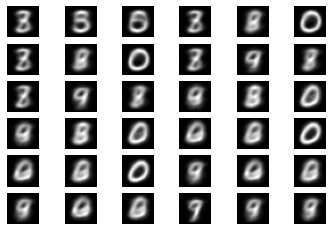

epoch : 0 | #batch : 200 | batch average loss: 626.66259765625
epoch : 0 | #batch : 400 | batch average loss: 637.6475830078125
epoch[0/20] | loss:638.2808837890625
epoch : 1 | #batch : 200 | batch average loss: 641.2089233398438
epoch : 1 | #batch : 400 | batch average loss: 633.2560424804688
epoch[1/20] | loss:637.7362060546875
epoch : 2 | #batch : 200 | batch average loss: 654.9140014648438
epoch : 2 | #batch : 400 | batch average loss: 635.5330810546875
epoch[2/20] | loss:637.668212890625
epoch : 3 | #batch : 200 | batch average loss: 618.1908569335938
epoch : 3 | #batch : 400 | batch average loss: 663.0093994140625
epoch[3/20] | loss:637.61669921875
epoch : 4 | #batch : 200 | batch average loss: 665.9822998046875
epoch : 4 | #batch : 400 | batch average loss: 650.6326904296875
epoch[4/20] | loss:637.6005859375
epoch : 5 | #batch : 200 | batch average loss: 632.9231567382812
epoch : 5 | #batch : 400 | batch average loss: 632.8798828125
epoch[5/20] | loss:637.5806884765625
epoch : 6

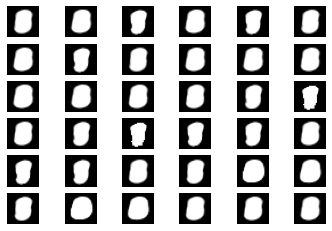

In [8]:
betas = [0.5, 1.0, 2.0, 3.0, 4.0]
funcs=[F.mse_loss,F.cross_entropy]
for beta in betas:
    for func in funcs:
        model = train_module(beta,func)
        # evaluation 测试生成效果，从正态分布随机采样z
        print(beta)
        z = torch.randn((batch_sz, Z_dim))
        logits = model.decode(z.cuda())  # 仅通过解码器生成图片
        x_hat = torch.sigmoid(logits)  # 转换为像素范围
        x_hat = x_hat.view(128, 28, 28).detach().cpu().numpy()*255.
        # 展示图片
        _ ,axes = plt.subplots(6, 6)
        for i in range(6):
            for j in range(6):
                axes[i][j].axis('off') 
                axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
        print("损失函数为",func)
        print("beta值为",beta)
        plt.show()

In [9]:
module = train_module(1, F.mse_loss)

epoch : 0 | #batch : 200 | batch average loss: 44.03926467895508
epoch : 0 | #batch : 400 | batch average loss: 44.03076171875
epoch[0/20] | loss:44.938594818115234
epoch : 1 | #batch : 200 | batch average loss: 40.544681549072266
epoch : 1 | #batch : 400 | batch average loss: 41.960567474365234
epoch[1/20] | loss:41.130157470703125
epoch : 2 | #batch : 200 | batch average loss: 41.45075607299805
epoch : 2 | #batch : 400 | batch average loss: 41.35761260986328
epoch[2/20] | loss:40.50993728637695
epoch : 3 | #batch : 200 | batch average loss: 41.65595626831055
epoch : 3 | #batch : 400 | batch average loss: 39.16263198852539
epoch[3/20] | loss:40.150760650634766
epoch : 4 | #batch : 200 | batch average loss: 42.84925842285156
epoch : 4 | #batch : 400 | batch average loss: 41.28178787231445
epoch[4/20] | loss:39.94636154174805
epoch : 5 | #batch : 200 | batch average loss: 42.01182174682617
epoch : 5 | #batch : 400 | batch average loss: 39.469200134277344
epoch[5/20] | loss:39.7216339111

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:17<00:00,  1.16it/s]


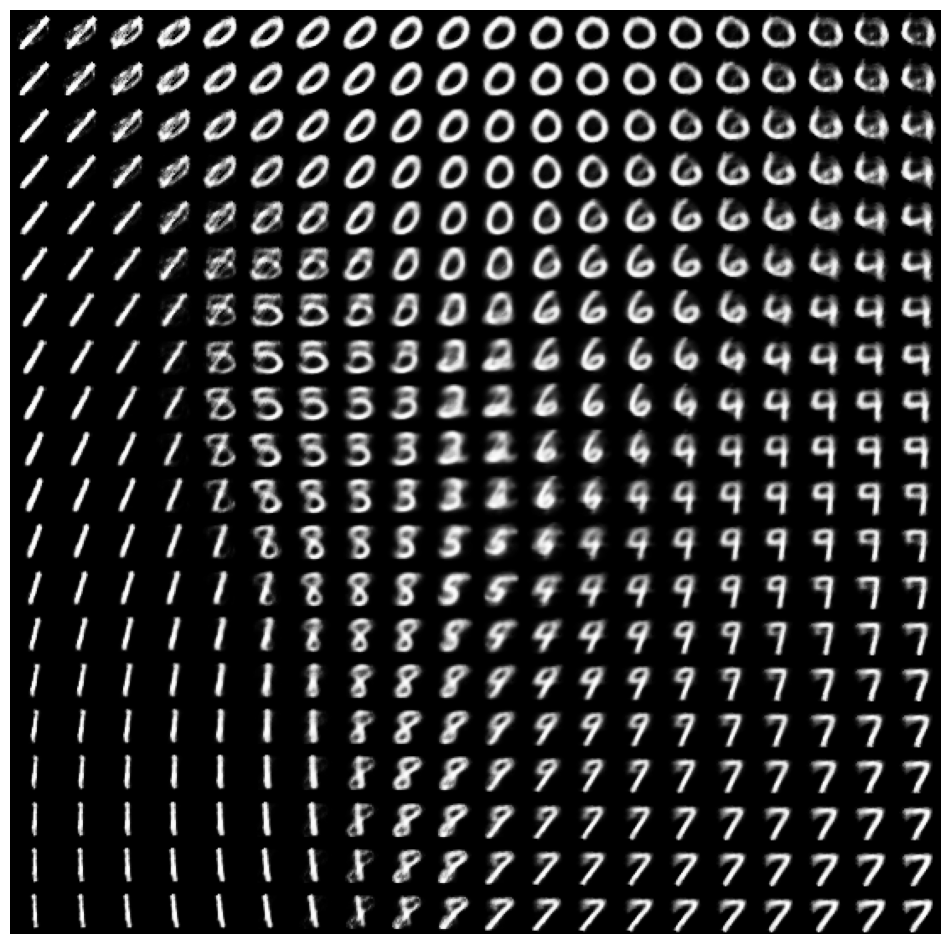

In [9]:
# x 范围：(-2.5,2.5)
# y 范围：(-2.5,2.5)
import tqdm
# 利用 plt 在这个范围内，每隔0.25在这个latent space上面采样一次，然后用 decoder 生成图片
plt.figure(figsize=(30, 30))
for i in tqdm.tqdm(range(20)):
    for j in range(20):
        # x 范围：(-2.5,2.5)
        # y 范围：(-2.5,2.5)
        x = -2.5 + i*0.25
        y = -2.5 + j*0.25
        z = torch.tensor([x, y]).to('cuda')
        o = module.decode(z)
        digit = o.detach().to('cpu').numpy().reshape(28, 28)
        plt.subplot(50, 50, i*50+j+1)
        plt.imshow(digit, cmap='Greys_r')
        plt.axis('off')
        # 让图片之间没有白边
        plt.subplots_adjust(wspace=0, hspace=0)

此外分别使用交叉熵和L2作为损失函数，我们发现L2生成的结果有点模糊，而交叉熵基本是一坨极难分辨的图片，下方二图分别为交叉熵和L2损失的

![jupyter](./cross.png)

![jupyter](./L2.png)

## 中级要求

对于VAE网络的损失函数$$ELBO=E_{z∼q(z|x)}logp(x|z)−KL(q(z|x)||p(z))$$

由于任意分布都可以用若干个高斯分布进行拟合，因此VAE假设$q(z|x)$服从高斯分布，即$q(z|x)∼N(\mu,\sigma^2)$ 。

同时，隐变量$p(z)$的服从的分布可以是任意的，因此VAE假设其服从正态分布，即$p(z)∼N(0,1)$，可得：
$$KL(q(z|x)||p(z))=KL(N(\mu,\sigma^2)||N(0,1))$$

此时原式化作$$ELBO=E_{z∼q(z|x)}logp(x|z)−KL(N(\mu,\sigma^2)||N(0,1))$$

对于第一项来说，我们选择用蒙特卡洛模拟采样的方法，根据$z$的概率分布采样$N$个点，即
$$E_{z∼q(z|x)}logp(x|z) = \frac{1}{N}\sum_{i=1}^{N}logp(x_i|z_i)， z∼q(z|x)$$

对于后者来说，我们在大二上的概率论中就已经学过，任何分布都可以考虑用高斯分布去拟合，因此VAE假设另一分布$q∼N(\mu, \sigma)$，对于我们的隐变量$p(z)$的服从的分布可以是任意的，因此，我们最终的推导结果如下：

![jupyter](./手写1.jpg)

![jupyter](./手写2.jpg)

至此我们完成了损失函数的推导。

## 高级要求

### βvae

βvae实际上就是在基础的vae的kl散度上乘了一个超参数β

根据论文作者的说法对于一个给定的观测x，我们用概率分布qφ(z|x)来描述潜在因子z的推断后验构型。
我们的目的是确保推断出的潜在因子qφ(z|x)以解纠缠的方式捕获生成因子v。有条件依赖的数据生成因子w可以保持纠缠在z的一个单独子集中，该子集中不用来表示v。
为了鼓励在推断的qφ(z|x)中的这种分离性质，我们通过尝试将其与先验的p(z)匹配来对其引入一个约束。它既可以控制潜在信息瓶颈的能力，又体现了上述统计独立性的需求。
因此，将先验设置为一个各向同性单位高斯(p(z)=N(0，I))，可以满足这一点。
对于β-vae的损失来说：β是正则化系数，它约束了潜在信息通道z的容量，并由于高斯先验p(z)的各向同性，对学习到的后验施加隐式独立压力。
当在信息保存（重建成本作为正则化）和潜在信道容量限制（β>1）之间找到正确的平衡时，就会出现解纠缠表示。文中通过实验选择的是β=4的时候效果最好。


具体的代码实现我们在上面vae实现的时候便已经加入了参数β，此处不再重复，我们测试了β=0.5,1,2,3,4的情况（其中β=1其实就是最普通的vae），不过我们并没有感受到很好的效果提升。。。

### 可视化的创新(输出隐变量)

这一部分主要是将我们中间的隐变量Z在坐标轴上面进行输出，这样可以更直观地观察隐变量的分布，然而我们的z的维度是很高的，并不能直接投影在二维坐标或者三维坐标中，所以我们需要使用到一些降维算法来辅助实现隐变量的可视化。

那么降维算法之前我们学过的有PCA降维，不过PCA主要用在线性降维中，对我们图像处理来说，可能效果并不是很好，我们一般采用TSNE算法进行非线性降维，这样做的好处在于，使得相似的对象有更高的概率被选择，不相似的对象有较低概率被选择。

针对我们目前的$z$，因为其维度过高，所以我们一般的处理思路是先PCA降维到较低维度，再进行TSNE降维，最后可视化，这样的效果是更好的，因为这样首先会去掉很多冗余维度的干扰

D:\Anaconda3\envs\py39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Anaconda3\envs\py39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 0.180s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.056258
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.420319
[t-SNE] KL divergence after 300 iterations: 2.048922


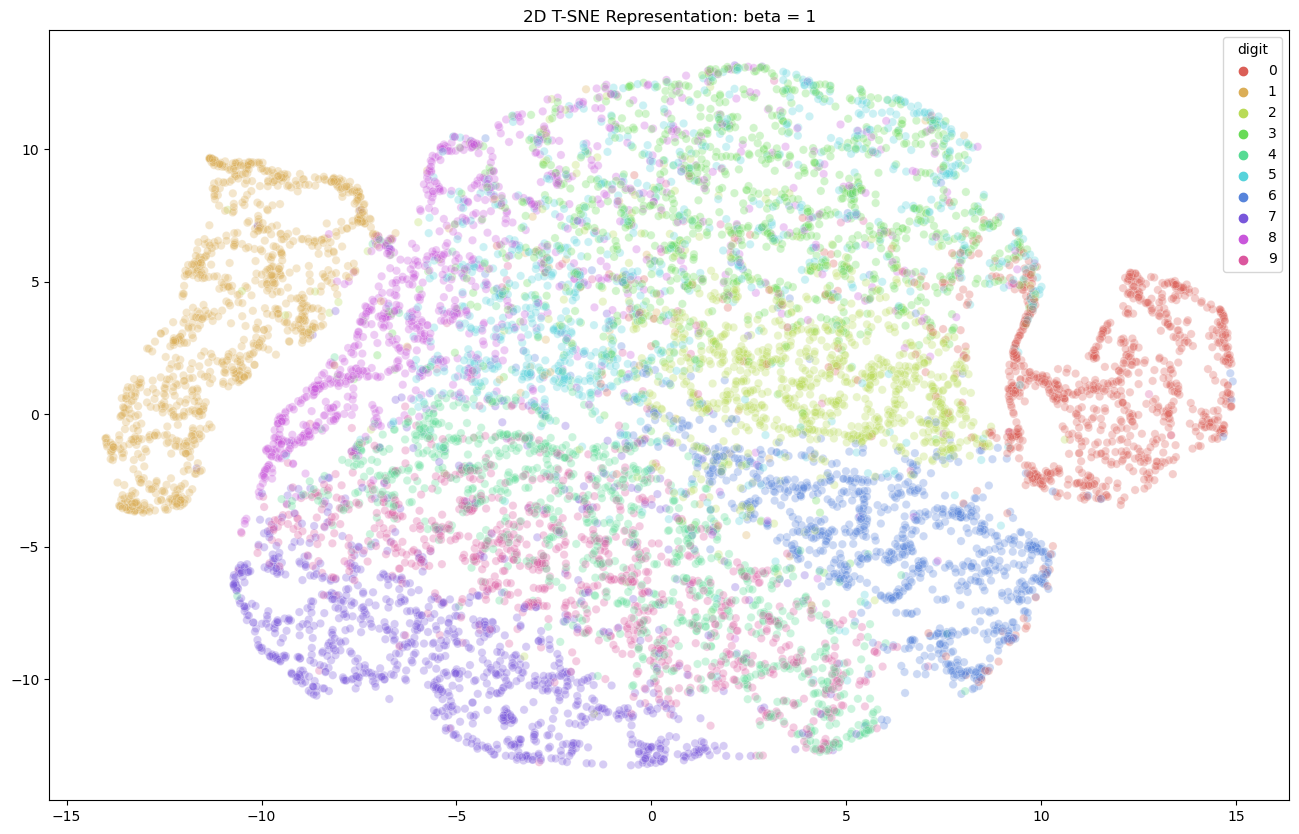

In [18]:
from sklearn.manifold import TSNE
import pandas as pd
import pickle
import seaborn as sb
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
betas = [0.5, 1.0, 2.0, 3.0, 4.0]
def scatter_tsne(z, z_embedded, labels, beta):
    title = '2D T-SNE Representation: beta = ' + str(beta)

    df = pd.DataFrame(z)
    df['digit'] = labels.numpy()
    plt.figure(figsize=(16,10))
    sb.scatterplot(
    x=z_embedded[:,0], y=z_embedded[:,1],
    hue='digit',
    palette=sb.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
    ).set(title=title)

dataIter = Data.DataLoader(dataset, batch_size=10000, shuffle=False)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

# for beta in enumerate(betas):
for i, (data, labels) in enumerate(dataIter):
    data = flatten(data)
    data = data.to('cuda')
    mu, log_var = module.encode(data)
    z = module.reparameterize(mu, log_var)
    labels = labels

z = z.cpu().detach().numpy()
z = StandardScaler().fit_transform(z)
pca=PCA(n_components=2)
z=pca.fit_transform(z)
z_embedded = tsne.fit_transform(z)

scatter_tsne(z, z_embedded, labels, 1)

根据上面的结果我们不难看出，当前只训练了二十轮的模型效果还是不错的，不同类之间已经有较为清晰的分界线，随着训练次数的进一步累加，这个图像会更加得清晰分明，如下图

![jupyter](./理想图像.png)

### gan

GAN也是一种经典的深度生成模型。GAN的核心任务是：使生成器G产生的样本的概率分布尽量接近训练集的概率分布。判别器D的功能类似于逻辑回归，对于一个样本x,判别器D(x)将给出该样本来源于训练集的概率，所以一个“完美”的判别器应该对来自于训练集的样本输出概率1，对来自于生成器的生成样本输出概率0；对于生成器G，它试图捕捉到训练集的本质模式，生成样本并将样本送至判别器D，最好能使该样本“欺骗”判别器，使判别器误认为该样本来源于训练集而输出概率1。通过这个对抗生成过程，GAN没有显式地建模P(x)，也可以得到满足P(x)分布的样本。

下面，我们搭建一个简单的gan模型，与上述vae模型进行一个对比。

In [10]:
import numpy as np
import torch 
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader # 用于加载数据，可实例化

In [11]:
image_size = [1,28,28]
latent_dim = 96
batch_size = 128

#### 生成器

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),  
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.GELU(), 
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Linear(1024, np.prod(image_size, dtype=np.int32)), 
            nn.Sigmoid(),
        )
        
    def forward(self, z): 
        output = self.model(z)
        image = output.reshape(z.shape[0], *image_size) 
        return image

#### 判别器

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__() 
        self.model = nn.Sequential(
            nn.Linear(np.prod(image_size,dtype=np.int32), 512),
            nn.GELU(),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, image): 
        prob = self.model(image.reshape(image.shape[0], -1)) 
        return prob

In [14]:
dataset = torchvision.datasets.MNIST("MNIST",train=True,download=False,
                                    transform = torchvision.transforms.Compose([
                                        torchvision.transforms.Resize(28),
                                        torchvision.transforms.ToTensor(),
                                    ]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True) 

In [15]:
generator = Generator()
discriminator = Discriminator()

g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0003, betas=(0.4, 0.8), weight_decay=0.0001)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0003, betas=(0.4, 0.8), weight_decay=0.0001)

loss_fn = nn.BCELoss()
labels_one = torch.ones(batch_size, 1)
labels_zero = torch.zeros(batch_size, 1)

In [16]:
num_epoch = 50

for epoch in range(num_epoch):
    for i, mimi_batch in enumerate(dataloader):
        gt_images, _ = mimi_batch
        z = torch.randn(batch_size,latent_dim) # 随机生成高斯变量，latent_dim表示隐变量维度
        pred_images = generator(z)
        
        g_optimizer.zero_grad()
        recons_loss = torch.abs(pred_images-gt_images).mean()
        g_loss = recons_loss * 0.05 + loss_fn(discriminator(pred_images), labels_one)
        g_loss.backward()
        g_optimizer.step()
        
        d_optimizer.zero_grad()
        real_loss = loss_fn(discriminator(gt_images), labels_one)
        fake_loss = loss_fn(discriminator(pred_images.detach()), labels_zero)
        d_loss = 0.5 * (real_loss + fake_loss)
        d_loss.backward()
        d_optimizer.step()
        
        if i % 200 == 0 and i > 0:
            print("epoch : {0} | #batch : {1} | g_loss: {2}, d_loss: {3}"
                  .format(epoch, i, g_loss.cuda().item(), d_loss.cuda().item()))

        # 输出epoch信息
    print("epoch[{}/{}]"
          .format(epoch, num_epoch))

epoch : 0 | #batch : 200 | g_loss: 8.876077651977539, d_loss: 0.00013753576786257327
epoch : 0 | #batch : 400 | g_loss: 1.8683243989944458, d_loss: 0.5862848162651062
epoch[0/50]
epoch : 1 | #batch : 200 | g_loss: 1.0226833820343018, d_loss: 0.68585205078125
epoch : 1 | #batch : 400 | g_loss: 0.7367110252380371, d_loss: 0.6015353798866272
epoch[1/50]
epoch : 2 | #batch : 200 | g_loss: 0.9295159578323364, d_loss: 0.5965051054954529
epoch : 2 | #batch : 400 | g_loss: 1.2247748374938965, d_loss: 0.6574792861938477
epoch[2/50]
epoch : 3 | #batch : 200 | g_loss: 0.5678169131278992, d_loss: 0.6767138242721558
epoch : 3 | #batch : 400 | g_loss: 0.5953811407089233, d_loss: 0.6734637022018433
epoch[3/50]
epoch : 4 | #batch : 200 | g_loss: 1.1081639528274536, d_loss: 0.5190849900245667
epoch : 4 | #batch : 400 | g_loss: 0.6412250995635986, d_loss: 0.6507620811462402
epoch[4/50]
epoch : 5 | #batch : 200 | g_loss: 1.267551064491272, d_loss: 0.5445516705513
epoch : 5 | #batch : 400 | g_loss: 0.8869

epoch : 46 | #batch : 200 | g_loss: 1.286314606666565, d_loss: 0.4961615204811096
epoch : 46 | #batch : 400 | g_loss: 1.304379940032959, d_loss: 0.4590069651603699
epoch[46/50]
epoch : 47 | #batch : 200 | g_loss: 1.0880860090255737, d_loss: 0.5304211974143982
epoch : 47 | #batch : 400 | g_loss: 1.2306690216064453, d_loss: 0.5067400336265564
epoch[47/50]
epoch : 48 | #batch : 200 | g_loss: 1.2606697082519531, d_loss: 0.5059787034988403
epoch : 48 | #batch : 400 | g_loss: 1.0218416452407837, d_loss: 0.5683214664459229
epoch[48/50]
epoch : 49 | #batch : 200 | g_loss: 1.1644095182418823, d_loss: 0.5090622901916504
epoch : 49 | #batch : 400 | g_loss: 1.1556473970413208, d_loss: 0.45672914385795593
epoch[49/50]


torch.Size([128, 1, 28, 28])


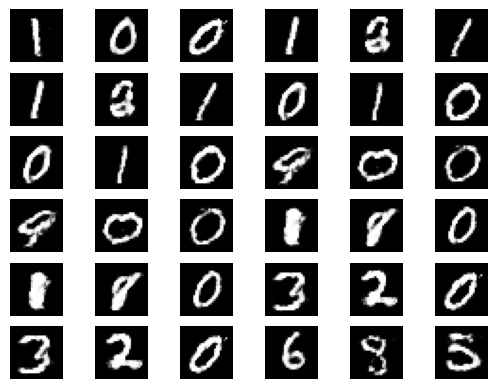

In [17]:
# evaluation 测试生成效果，从正态分布随机采样z
z = torch.randn((batch_size, latent_dim))
logits = generator.forward(z)
print(logits.shape)
x_hat = torch.sigmoid(logits)  # 转换为像素范围
x_hat = x_hat.view(128, 28, 28).detach().numpy()*255.
# 展示图片
_ ,axes = plt.subplots(6, 6)
for i in range(6):
    for j in range(6):
        axes[i][j].axis('off') 
        axes[i][j].imshow(x_hat[i*3+j], cmap='gray')
plt.show()

从结果中我们可以看出，GAN利用生成对抗网络在图片的生成质量上是很好的，图片清晰特征明显。但是在GAN的训练中，生成对抗网络的博弈理论只是单纯的让G生成的图片骗过D，这个会让G钻空子。一旦骗过了D，不论图像合不合理就作为输出。以上原因导致GAN生成的图片有的时候看起来有些抽象。

VAE是利用已有图片在encoder下编码生成潜在向量，这个向量在服从高斯分布的情况下很好的保留了原图像的特征。在decoder解码后得到的图片会更加的合理与准确。但是图像在训练的时候损失函数只能用MSE之类的粗略误差衡量，这就导致生成的图片不能很好地保留原图像的清晰度，就会使得图片看上去有点模糊。优点就是VAE生成的图片合理，学习到的潜在向量可以很好地还原出图像。

### vae-gan

这一部分主要是结合了vae与gan以期获得更好的效果

vae的优缺点：虽然vae通过从单位高斯分布进行采样然后传给解码器就能很方便的生成图片，且较为容易训练，但是其较为模糊或者说难以还原图像的细节，或许是因为VAE试图把它们压缩到一个低维的潜空间，这难免导致特征的损失，而如果使用比较大的潜空间向量维数可能会导致是采样质量较差，因为潜空间变大了，高维空间的离散点映射过来，不再容易保证连续性。与此同时，把函数限制在有限维度的高斯函数或其他分布上，也会导致表达能力有所下降，可能难以对真实分布进行逼近，从而导致模糊

解决的方法：
那我们不妨结合GAN与VAE，通过GAN	约束VAE，让其生成的图片效果更好，在论文中给出的理想实现为：


![jupyter](./vae-ganfig1.png)

我们通过输入图像x，通过encoder为隐变量z再解码生成图像，这作为gan的生成器，再和原图像对比训练判别器，如此迭代，但是因为实际实现中复杂的细节，论文中采用了如下结构，本次大作业也采用了同样的结构

![jupyter](./vae-ganfig2.png)

具体流程如下：

![jupyter](./vae-gancode.png)

训练20轮后的结果，明显清晰

![jupyter](./vae-gan20.jpg)

#### 实现：

In [19]:
import os
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置画图的尺寸
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
i=0
def show_images(images): # 定义画图工具
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 
def deprocess_img(x):
    return (x + 1.0) / 2.0 

In [20]:
#数据处理
im_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize([0.5], [0.5]) # 标准化
])
train_set = MNIST('./mnist',download=True, transform=im_tfs)
train_data = DataLoader(train_set, batch_size=128, shuffle=True)

In [21]:
 #定义编码器
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20) # mean
        self.fc22 = nn.Linear(400, 20) # var

    def encode(self, x): #编码层
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() #e**(x/2)
        eps = torch.FloatTensor(std.size()).normal_()
        if torch.cuda.is_available():
            eps = Variable(eps.cuda())
        else:
            eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x) # 编码
        z = self.reparametrize(mu, logvar) # 重新参数化成正态分布
        KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
        KLD = torch.sum(KLD_element).mul_(-0.5)
        return z,KLD # 解码，同时输出均值方差

In [22]:
NOISE_DIM=20
bs=128

In [23]:
class Decoder(nn.Module): 
    def __init__(self, noise_dim=NOISE_DIM):
        super(Decoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 7 * 7 * 128),
            nn.ReLU(True),
            nn.BatchNorm1d(7 * 7 * 128)
        )
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),#128,64,3,3
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1),#128,1,1,1
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7) # reshape 通道是 128，大小是 7x7
        x = self.conv(x)
        return x

In [24]:
 class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1),#24,24
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),#12,12
            nn.Conv2d(32, 64, 5, 1),#8,8
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)#4,4
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        self.f=nn.Sequential(
            nn.Conv2d(64,1,4,2,1),
            nn.AvgPool2d(2)
        )#1,1
        
    def forward(self, x):
        x = self.conv(x)
        f=self.f(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x,f.squeeze()

In [25]:
Gen=Decoder().cuda()
Dis=Discriminator().cuda()
sample_noise = (torch.rand(128, 20) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
g_fake_seed = Variable(sample_noise).cuda()
fake_images = Gen(g_fake_seed) # 生成的假的数据
print(fake_images.shape)
logits_fake,_ = Dis(fake_images) # 判别网络得分
print(logits_fake.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128, 1])


In [26]:
Enc=Encoder().cuda()
fake_images=fake_images.view(128,-1)
print(fake_images.shape)
z,kld=Enc(fake_images)
print(z.shape)

torch.Size([128, 784])
torch.Size([128, 20])


In [27]:
print(torch.cuda.is_available())
Enc=Encoder().cuda()
Gen=Decoder().cuda()
D=Discriminator().cuda()
E_trainer = torch.optim.Adam(Enc.parameters(), lr=1e-3)
G_trainer = torch.optim.Adam(Gen.parameters(), lr=3e-4, betas=(0.5, 0.999))
D_trainer = torch.optim.Adam(D.parameters(), lr=3e-4, betas=(0.5, 0.999))

True


In [28]:
def lossD(scores_real, scores_fake0,scores_fake1):
    loss = 0.5 * ((scores_real - 1) ** 2).mean() + 0.5 * (scores_fake0 ** 2).mean()+0.5 * (scores_fake1 ** 2).mean()
    return loss

def lossGD(scores_fake):
    loss = 0.5 * ((scores_fake - 1) ** 2).mean()
    return loss

In [29]:
def training(epochs=20):
    for epoch in range(epochs):
        T_loss_D = []
        T_loss_G = []
        T_loss_GD = []
        T_loss_kld = []
        i=0
        for x_r,_ in train_data:
            i+=1
            if i==469:
              break
            x_r=x_r.cuda()
            x_r0=x_r.view(bs,-1)
            z,kld=Enc(x_r0)
            x_f=Gen(z)
            sample_noise = (torch.rand(bs, NOISE_DIM) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).cuda()
            x_p = Gen(g_fake_seed) # 生成的假的数据
            ld_r,fd_r = D(x_r)
            ld_f,fd_f = D(x_f)
            ld_p,fd_p = D(x_p)
            
            #---------------------D training --------------------------------
            loss_D=lossD(ld_r,ld_p,ld_f)
            D_trainer.zero_grad()
            loss_D.backward()
            D_trainer.step() 

            #------------------------G & E  training------------------
            x_r0=x_r.view(bs,-1)
            z,kld=Enc(x_r0)
            x_f=Gen(z)
            sample_noise = (torch.rand(bs, NOISE_DIM) - 0.5) / 0.5 # -1 ~ 1 的均匀分布
            g_fake_seed = Variable(sample_noise).cuda()
            x_p = Gen(g_fake_seed) # 生成的假的数据
            ld_r,fd_r = D(x_r)
            ld_f,fd_f = D(x_f)
            ld_p,fd_p= D(x_p)
            loss_GD=lossGD(ld_p)
            loss_G = 0.5 * (0.01*(x_f - x_r).pow(2).sum() + (fd_f - fd_r.pow(2).sum())) / bs   
            G_trainer.zero_grad()
            E_trainer.zero_grad()
            kld.backward(retain_graph=True)
            (0.01*loss_G+loss_GD).backward(torch.ones_like(loss_G))
            G_trainer.step()
            E_trainer.step()
        imgs_numpy = deprocess_img(x_p.data.cpu().numpy())
        print("epoch:", epoch)
        show_images(imgs_numpy[0:16])

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
epoch: 10
epoch: 11
epoch: 12
epoch: 13
epoch: 14
epoch: 15
epoch: 16
epoch: 17
epoch: 18
epoch: 19


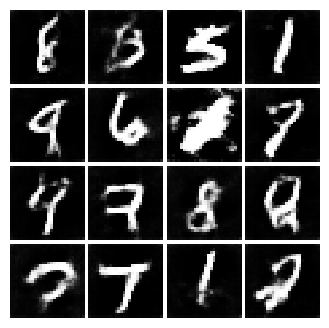

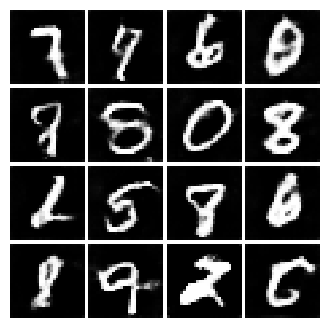

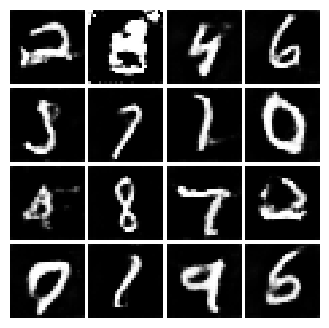

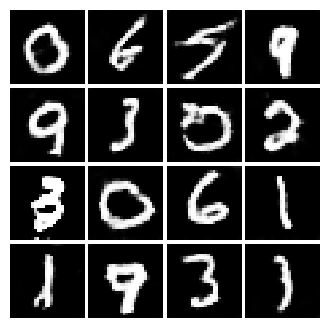

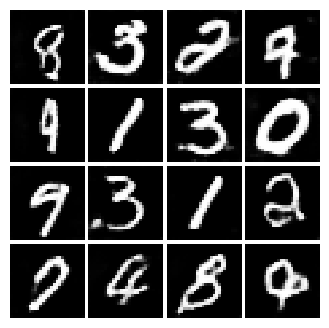

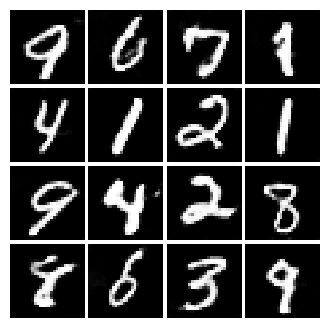

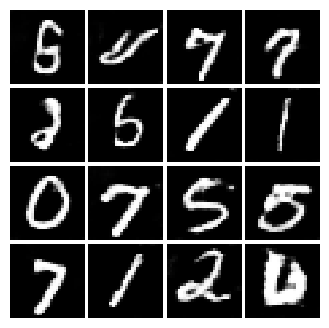

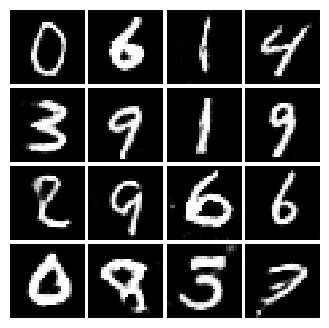

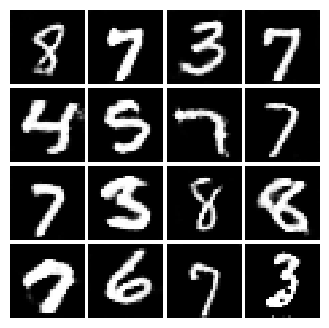

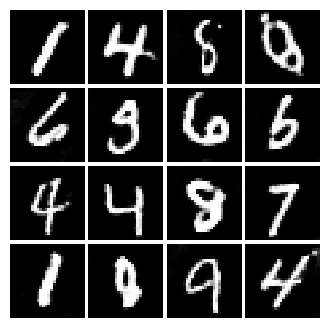

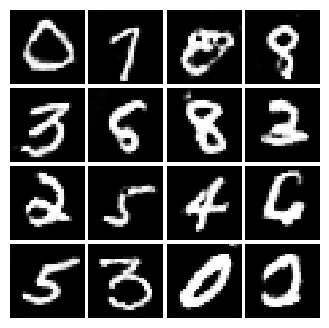

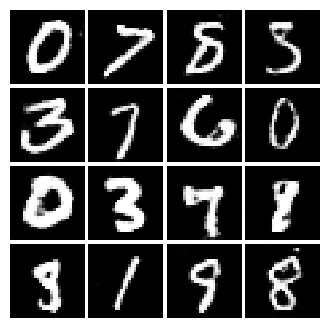

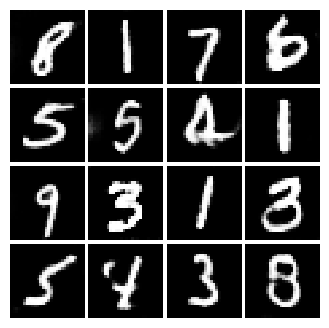

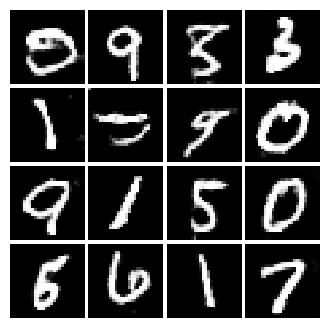

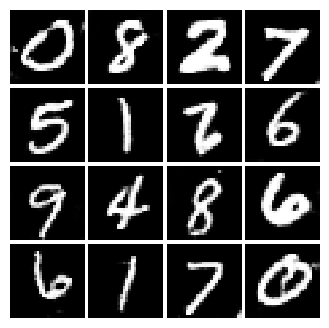

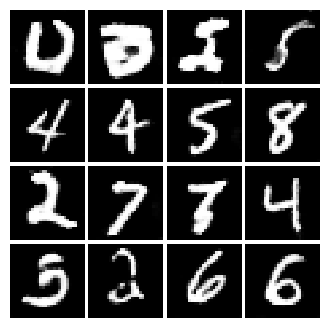

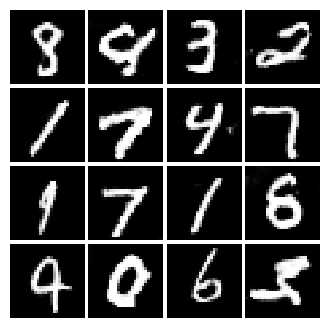

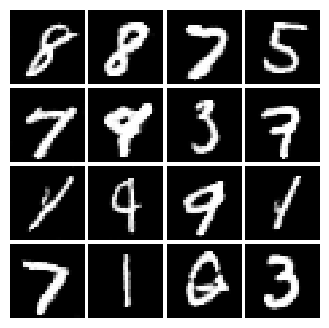

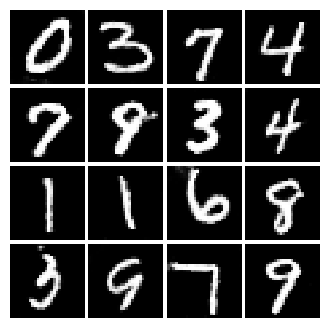

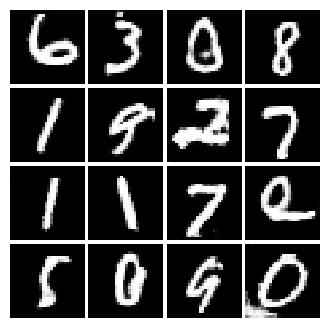

In [30]:
 training()